<div style="width:90%;
            margin:10px;
            padding:8px;
            border:2px solid #FF0000;
            border-radius:20px;
            font-weight:bold;
            font-size:2.5em;
            text-align:center;">
The Ducted Fan Problem
</div>


<div style="width:90%;
            margin:9px;
            font-size:1em;">
            
*The Ducted Fan Problem:* This problem consists of a planar ducted fan system.                              
The problem is inspired from : Graichen, K., & Petit, N. (2009). Incorporating a class of constraints into the dynamics of optimal control problems. Optimal Control Applications and Methods, 30(6), 537-561.      
We solve the problem using the [JuMP](https://jump.dev/) and [OptimalControl](https://control-toolbox.org/OptimalControl.jl/stable/) packages in Julia then we compare the results.

1. [JuMP Formulation](#jump)
2. [OptimalControl Formulation](#oc)
3. [Comparison](#comp)

</div>

In [1]:
import Pkg
Pkg.activate("..");

  Activating project at `c:\Users\hajje\Dropbox\PC\Desktop\Stage\COTS`


## 1. Solving with JuMP <a id='jump'></a>

In [2]:
using JuMP , Ipopt
include("../Problems/JuMP/ducted_fan_JMP.jl")
nh=100
DuctedFanJMP = ducted_fan_JMP(;N=nh);

set_optimizer(DuctedFanJMP,Ipopt.Optimizer)
set_attribute(DuctedFanJMP, "print_level", 5)
set_optimizer_attribute(DuctedFanJMP,"tol",1e-8)
set_optimizer_attribute(DuctedFanJMP,"constr_viol_tol",1e-6)
set_optimizer_attribute(DuctedFanJMP,"max_iter",1000)
set_optimizer_attribute(DuctedFanJMP,"mu_strategy","adaptive")
set_optimizer_attribute(DuctedFanJMP,"linear_solver","mumps")

In [3]:
println("Solving...")
optimize!(DuctedFanJMP)
println()

# Display results
if termination_status(DuctedFanJMP) == MOI.OPTIMAL
    println("  Solution is optimal")
elseif  termination_status(DuctedFanJMP) == MOI.LOCALLY_SOLVED
    println("  (Local) solution found")
elseif termination_status(DuctedFanJMP) == MOI.TIME_LIMIT && has_values(DuctedFanJMP)
    println("  Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("  The model was not solved correctly.")
end
println("  objective value = ", objective_value(DuctedFanJMP))
println()

Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4212
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    27106

Total number of variables............................:      809
                     variables with only lower bounds:        1
                variables with lower and upper bounds:      303
                     variables with only upper bounds:        0
Total number of equality constraints.................:      612
Total number of i

In [4]:
# Retrieves values of variables
x1 = DuctedFanJMP[:x1];
v1 = DuctedFanJMP[:v1];
x2 = DuctedFanJMP[:x2];
v2 = DuctedFanJMP[:v2];
α = DuctedFanJMP[:α];
vα = DuctedFanJMP[:vα];

con_x1 = DuctedFanJMP[:con_x1];
con_v1 = DuctedFanJMP[:con_v1];
con_x2 = DuctedFanJMP[:con_x2];
con_v2 = DuctedFanJMP[:con_v2];
con_α = DuctedFanJMP[:con_α];
con_vα = DuctedFanJMP[:con_vα];

tf = DuctedFanJMP[:tf];
Δtt = value.(tf)/nh;
t = Vector((0:nh)*Δtt); 
p = [ [ dual(con_x1[nh]), dual(con_v1[nh]), dual(con_x2[nh]), dual(con_v2[nh]), dual(con_α[nh]), dual(con_vα[nh]) ] ];
p = - [[[ dual(con_x1[i]), dual(con_v1[i]), dual(con_x2[i]), dual(con_v2[i]), dual(con_α[i]), dual(con_vα[i]) ] for i in 1:nh];p];


x1 = Vector(value.(x1)) ;
v1 = Vector(value.(v1)) ;
x2 = Vector(value.(x2)) ;
v2 = Vector(value.(v2)) ;
α = Vector(value.(α)) ;
vα = Vector(value.(vα)) ;

x =  [ [ x1[i], v1[i], x2[i], v2[i], α[i], vα[i] ] for i in 1:nh+1];

u1 = Vector(value.(DuctedFanJMP[:u1])) ;
u2 = Vector(value.(DuctedFanJMP[:u2])) ;

u = [ [ u1[i], u2[i] ] for i in 1:nh+1];



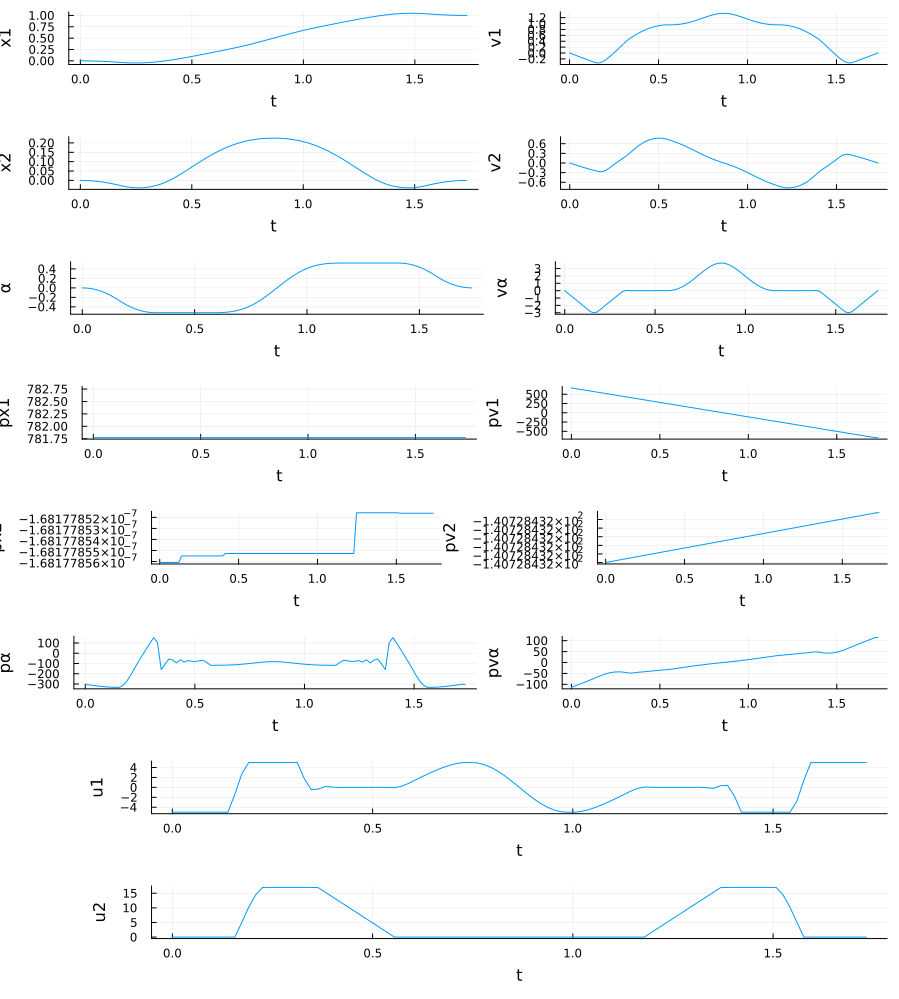

In [5]:
# For plotting results
using Plots

x1_plot = plot(t, [ x[i][1] for i in 1:nh+1], xlabel = "t", ylabel = "x1", legend = false)
v1_plot = plot(t, [ x[i][2] for i in 1:nh+1], xlabel = "t", ylabel = "v1", legend = false)
x2_plot = plot(t, [ x[i][3] for i in 1:nh+1], xlabel = "t", ylabel = "x2", legend = false)
v2_plot = plot(t, [ x[i][4] for i in 1:nh+1], xlabel = "t", ylabel = "v2", legend = false)
α_plot = plot(t, [ x[i][5] for i in 1:nh+1], xlabel = "t", ylabel = "α", legend = false)
vα_plot = plot(t, [ x[i][6] for i in 1:nh+1], xlabel = "t", ylabel = "vα", legend = false)

px1_plot = plot(t, [ p[i][1] for i in 1:nh+1], xlabel = "t", ylabel = "px1", legend = false)
pv1_plot = plot(t, [ p[i][2] for i in 1:nh+1], xlabel = "t", ylabel = "pv1", legend = false)
px2_plot = plot(t, [ p[i][3] for i in 1:nh+1], xlabel = "t", ylabel = "px2", legend = false)
pv2_plot = plot(t, [ p[i][4] for i in 1:nh+1], xlabel = "t", ylabel = "pv2", legend = false)
pα_plot = plot(t, [ p[i][5] for i in 1:nh+1], xlabel = "t", ylabel = "pα", legend = false)
pvα_plot = plot(t, [ p[i][6] for i in 1:nh+1], xlabel = "t", ylabel = "pvα", legend = false)

u1_plot = plot(t, [ u[i][1] for i in 1:nh+1], xlabel = "t", ylabel = "u1", legend = false)
u2_plot = plot(t, [ u[i][2] for i in 1:nh+1], xlabel = "t", ylabel = "u2", legend = false)

layout = @layout [a b; c d; e f; g h; i j; k l; m; n]
x_plot = plot(x1_plot, v1_plot, x2_plot, v2_plot, α_plot, vα_plot, px1_plot, pv1_plot, px2_plot, pv2_plot, pα_plot, pvα_plot, u1_plot, u2_plot, layout = layout)
x_plot = plot!(x_plot, size=(900,1000))
display(x_plot)

## 2. Solving with OptimalControl <a id='oc'></a>

In [6]:
using OptimalControl
using NLPModelsIpopt
include("../Problems/OptimalControl/ducted_fan_OC.jl")
nh=100
DuctedFanOC = ducted_fan_OC(;N=nh)


The (autonomous) optimal control problem is given by:

    r = 0.2
    J = 0.05
    m = 2.2
    mg = 4.0
    μ = 1000.0
    tf ∈ R, variable
    t ∈ [0.0, tf], time
    x ∈ R⁶, state
    u ∈ R², control
    x1 = x₁
    v1 = x₂
    x2 = x₃
    v2 = x₄
    α = x₅
    vα = x₆
    u1 = u₁
    u2 = u₂
    tf ≥ 0.0, tf_con
    -(deg2rad(30.0)) ≤ α(t) ≤ deg2rad(30.0), α_con
    -5.0 ≤ u1(t) ≤ 5.0, u1_con
    0.0 ≤ u2(t) ≤ 17.0, u2_con
    x1(0) == 0.0, x1_i
    v1(0) == 0.0, v1_i
    x2(0) == 0.0, x2_i
    v2(0) == 0.0, v2_i
    α(0) == 0.0, α_i
    vα(0) == 0.0, vα_i
    x1(tf) == 1.0, x1_f
    v1(tf) == 0.0, v1_f
    x2(tf) == 0.0, x2_f
    v2(tf) == 0.0, v2_f
    α(tf) == 0.0, α_f
    vα(tf) == 0.0, vα_f
    ẋ(t) == dynamics(x(t), u(t))
    (tf / N) * ∫(2 * u1(t) ^ 2 + u2(t) ^ 2) + μ * tf → min

The (autonomous) optimal control problem is of the form:

    minimize  J(x, u, tf) = g(x(0.0), x(tf), tf) + ∫ f⁰(x(t), u(t), tf) dt, over [0.0, tf]

    subject to

        ẋ(t) = f(x(t), u(t), 

In [7]:
init = (variable = 1.0,)

(variable = 1.0,)

In [13]:
import HSL_jll
# Solve the problem
sol = OptimalControl.solve(DuctedFanOC,init=init, grid_size=nh,
            linear_solver="ma57",hsllib=HSL_jll.libhsl_path)

Method = (:direct, :adnlp, :ipopt)
This is Ipopt version 3.14.14, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:    13513
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3312

Total number of variables............................:     2710
                     variables with only lower bounds:        1
                variables with lower and upper bounds:      903
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2113
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0001000e+03 9.00e-01 4.89e-03   0.0 0.00e

CTBase.OptimalControlSolution

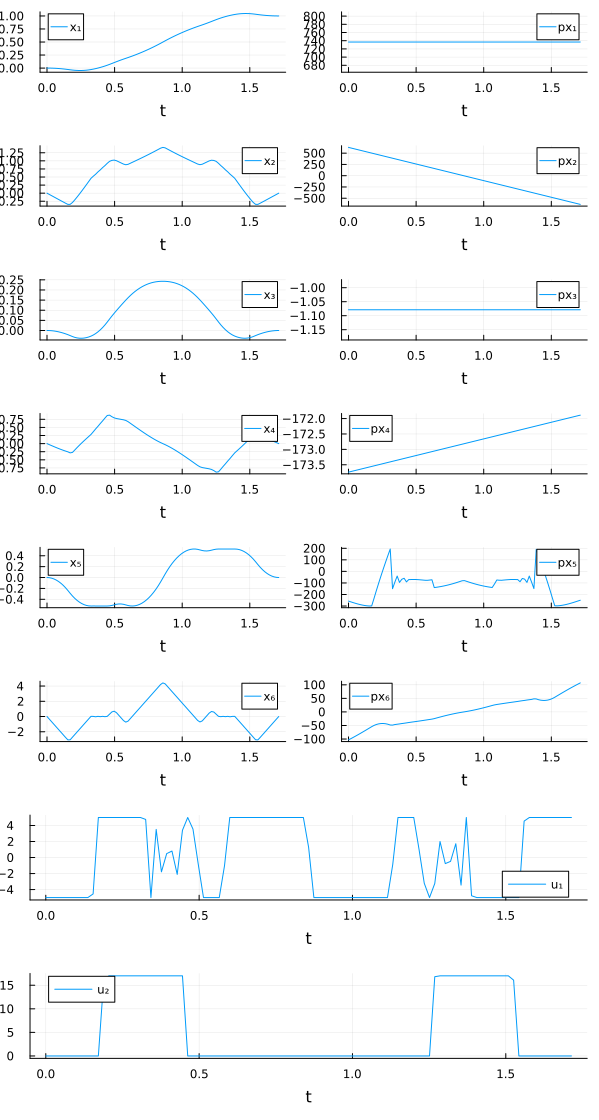

In [9]:
plot(sol)

## 3. Comparison <a id='comp'></a>

In [17]:
println("Objective value JuMP: ",objective_value(DuctedFanJMP))
println("Objective value OptimalControl: ",sol.objective)
println("tf JuMP: ",value(tf))
println("tf OptimalControl: ",sol.variable)

Objective value JuMP: 1911.5266729238958
Objective value OptimalControl: 1717.166469881068
tf JuMP: 1.7329106189167949
tf OptimalControl: 1.7133134455430143


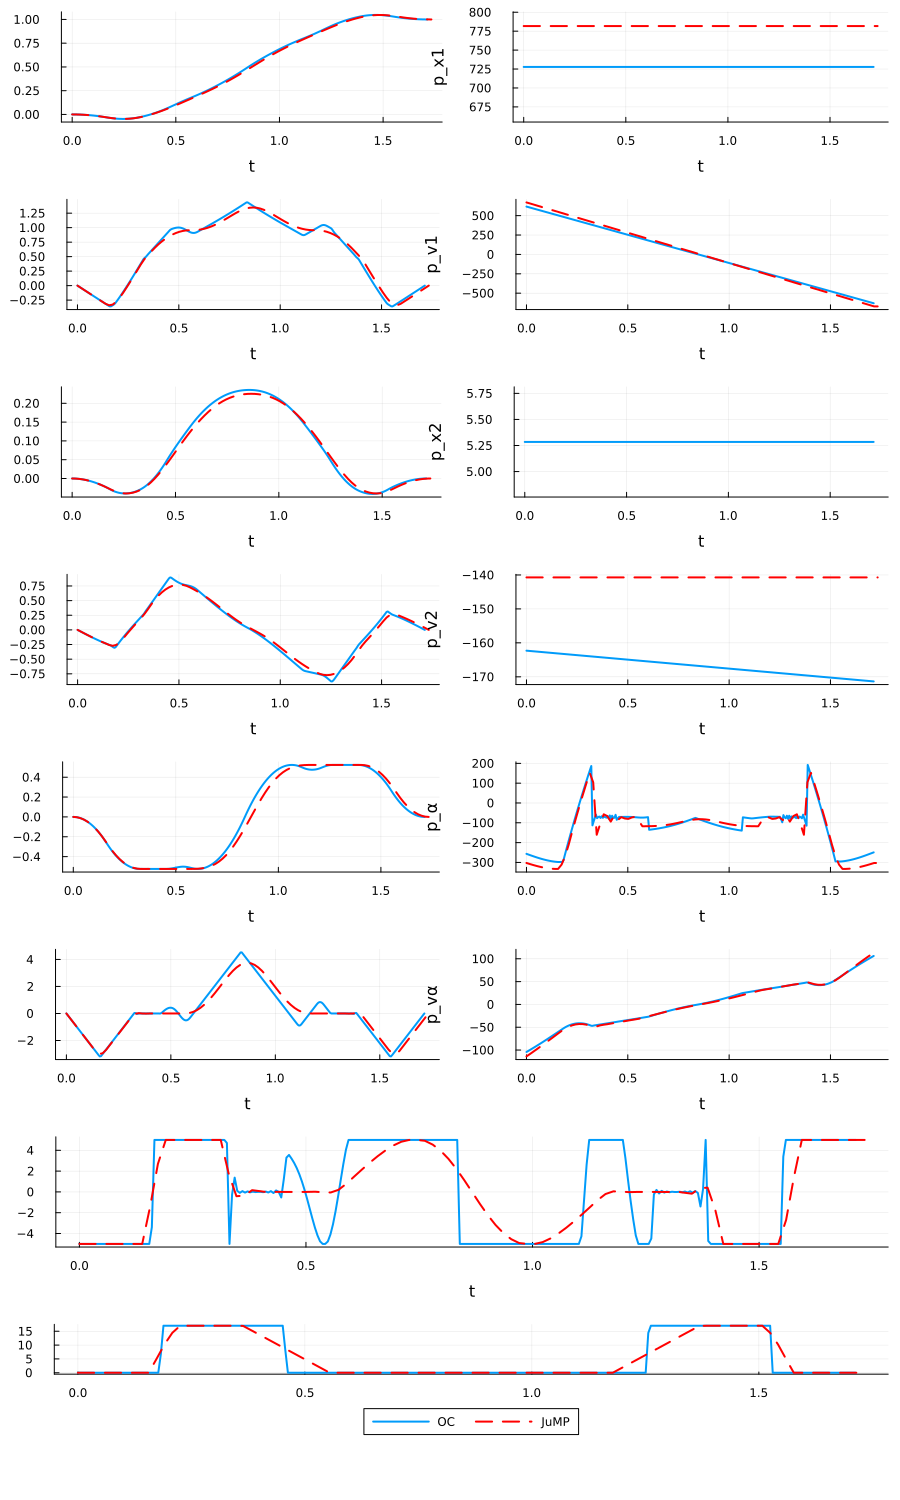

In [15]:
using Plots
p_x1 = plot(plot(sol)[1],line = 2)
p_x1 = plot!(t, [ x[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "x1", legend = false,line = 2, color = "red",linestyle=:dash)

p_v1 = plot(plot(sol)[2],line = 2)
p_v1 = plot!(t, [ x[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "v2", legend = false,line = 2, color = "red",linestyle=:dash)

p_x2 = plot(plot(sol)[3],line = 2)
p_x2 = plot!(t, [ x[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "x2", legend = false,line = 2, color = "red",linestyle=:dash)

p_v2 = plot(plot(sol)[4],line = 2)
p_v2 = plot!(t, [ x[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "v2", legend = false,line = 2, color = "red",linestyle=:dash)

p_α = plot(plot(sol)[5],line = 2)
p_α = plot!(t, [ x[i][5] for i in 1:nh+1 ], xlabel = "t", ylabel = "α", legend = false,line = 2, color = "red",linestyle=:dash)

p_vα = plot(plot(sol)[6],line = 2)
p_vα = plot!(t, [ x[i][6] for i in 1:nh+1 ], xlabel = "t", ylabel = "vα", legend = false,line = 2, color = "red",linestyle=:dash)

p_px1 = plot(plot(sol)[7],line = 2)
p_px1 = plot!(t, [ p[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "p_x1", legend = false,line = 2, color = "red",linestyle=:dash)

p_pv1 = plot(plot(sol)[8],line = 2)
p_pv1 = plot!(t, [ p[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "p_v1", legend = false,line = 2, color = "red",linestyle=:dash)

p_px2 = plot(plot(sol)[9],line = 2)
p_px2 = plot!(t, [ p[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "p_x2", legend = false,line = 2, color = "red",linestyle=:dash)

p_pv2 = plot(plot(sol)[10],line = 2)
p_pv2 = plot!(t, [ p[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "p_v2", legend = false,line = 2, color = "red",linestyle=:dash)

p_pα = plot(plot(sol)[11],line = 2)
p_pα = plot!(t, [ p[i][5] for i in 1:nh+1 ], xlabel = "t", ylabel = "p_α", legend = false,line = 2, color = "red",linestyle=:dash)

p_pvα = plot(plot(sol)[12],line = 2)
p_pvα = plot!(t, [ p[i][6] for i in 1:nh+1 ], xlabel = "t", ylabel = "p_vα", legend = false,line = 2, color = "red",linestyle=:dash)

p_u1 = plot(plot(sol)[13],line = 2)
p_u1 = plot!(t, [ u[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "u1", legend = false,line = 2, color = "red",linestyle=:dash)

p_u2 = plot(plot(sol)[14], label ="OC",line = 2)
p_u2 = plot!(t, [ u[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "u2", legend = false,label = "JuMP",line = 2, color = "red",linestyle=:dash)
p_u2 = plot!(legend=:outerbottom, legendcolumns=2)

layout = @layout [p_x1 p_px1; p_v1 p_pv1; p_x2 p_px2; p_v2 p_pv2; p_α p_pα; p_vα p_pvα; p_u1; p_u2]

x_plot = plot(p_x1, p_px1, p_v1, p_pv1, p_x2, p_px2, p_v2, p_pv2, p_α, p_pα, p_vα, p_pvα,p_u1, p_u2, layout = layout)
x_plot = plot!(size = (900, 1500))

display(x_plot)